In [ ]:
import os
from dotenv import load_dotenv

load_dotenv()

True

### Setup / Grabbing Documents

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://ai-office-hours.beehiiv.com/p/beyond-benchmarks",
    "https://ai-office-hours.beehiiv.com/p/evaluating-ai-agent-tool-selection",
    "https://ai-office-hours.beehiiv.com/p/re-ranking-rag",
    "https://ai-office-hours.beehiiv.com/p/quantizing-llms-llama-3",
    "https://ai-office-hours.beehiiv.com/p/llm-probing"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [doc for sublist in docs for doc in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs_list)

vector_store = Chroma.from_documents(
    documents=split_docs,
    embedding=OpenAIEmbeddings(),
    collection_name="rag-chroma",
    persist_directory="./chroma_db"
)
retriever = vector_store.as_retriever()

print("loaded docs and stored in chroma vector store")


loaded docs and stored in chroma vector store


In [ ]:
question = "tell me about ra ranking"
docs = retriever.invoke(question)

for doc in docs:
    print(doc.page_content[:50], doc.metadata['source'])

a way to run tests automatically, there is no reas https://ai-office-hours.beehiiv.com/p/re-ranking-rag
a way to run tests automatically, there is no reas https://ai-office-hours.beehiiv.com/p/re-ranking-rag
a way to run tests automatically, there is no reas https://ai-office-hours.beehiiv.com/p/re-ranking-rag
a way to run tests automatically, there is no reas https://ai-office-hours.beehiiv.com/p/re-ranking-rag


### Retrieval Grader

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


class GradeDocuments(BaseModel):
    binary_score: str = Field(description="A binary score of yes or no indicating if the document answers the question.")
    
    
llm = ChatOpenAI(model_name="gpt-4.1", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """Give a binary score of 'yes' or 'no' indicating if the document answers the question."""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("user", "Question: {question}\n\n Document: {document}\n")
])

retrieval_grader = grade_prompt | structured_llm_grader
for doc in docs:
    result = retrieval_grader.invoke({
        "question": question,
        "document": doc.page_content
    })
    print(f"binary score: {result.binary_score}")
    print(f"page content: {doc.page_content[:50]}\n")
    print(f"Document Source: {doc.metadata['source']}")


binary score: no
page content: a way to run tests automatically, there is no reas

Document Source: https://ai-office-hours.beehiiv.com/p/re-ranking-rag
binary score: no
page content: a way to run tests automatically, there is no reas

Document Source: https://ai-office-hours.beehiiv.com/p/re-ranking-rag
binary score: no
page content: a way to run tests automatically, there is no reas

Document Source: https://ai-office-hours.beehiiv.com/p/re-ranking-rag
binary score: no
page content: a way to run tests automatically, there is no reas

Document Source: https://ai-office-hours.beehiiv.com/p/re-ranking-rag


### Generate Components

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."),
    ("human", "Question: {question}\n\nContext: {context}")
])

for message in prompt.messages:
    print(type(message))
    print(message.prompt.template)
    print("----")

<class 'langchain_core.prompts.chat.SystemMessagePromptTemplate'>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
----
<class 'langchain_core.prompts.chat.HumanMessagePromptTemplate'>
Question: {question}

Context: {context}
----


In [ ]:
llm = ChatOpenAI(model_name="gpt-4.1", temperature=0)

def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print("Generated Answer:")
print(generation)

Generated Answer:
RA ranking, or re-ranking in the context of Retrieval-Augmented Generation (RAG) systems, refers to the process of reordering retrieved documents or passages to improve retrieval accuracy before passing them to the generation model. This is typically done by testing different re-rankers to see if they provide a net benefit to the system's performance. The goal is to ensure that the most relevant information is prioritized for the generative model to use.


### Question Re-write / The corrective Part

In [ ]:
bigger_llm = ChatOpenAI(model_name="gpt-4.1", temperature=0.1)

system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

re_writer_chain = re_write_prompt | bigger_llm | StrOutputParser()
improved_question = re_writer_chain.invoke({"question": question})
print("Improved Question:")
print(improved_question)

Improved Question:
What is the RA ranking and how is it determined?


### Graph State

In [ ]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    
    questions: str
    generation: str
    documents: List[str]
    times_transformed: int
    web_search: str

### The Node

In [52]:
def set_state(state):
    
    print("---- SET STATE ----")
    
    return {"times_transformed": 0}


def retrieve(state):
    print("state", state)
    
    print("---- RETRIEVE ----")
    question = state["questions"]
    docs = retriever.invoke(question)
    return {"documents": docs}


def generate(state):
    print("state", state)
    
    print("---- GENERATE ----")
    context = state["documents"]
    question = state["questions"]
    generation = rag_chain.invoke({"context": format_docs(context), "question": question})
    return {"generation": generation}



def transform_query(state):
    print("state", state)
    
    print("---- TRANSFORM QUERY ----")
    question = state["questions"]
    times_transformed = state["times_transformed"]
    times_transformed += 1
    print("updated times transformed:", times_transformed)
    improved_question = re_writer_chain.invoke({"question": question})
    print("improved question:", improved_question)
    return {"questions": improved_question, "times_transformed": times_transformed}


def grade_documents(state):
    print("state", state)

    print("---- GRADE DOCUMENTS ----")
    question = state["questions"]
    docs = state["documents"]
    graded_docs = []
    web_search = "No"
    for doc in docs:
        result = retrieval_grader.invoke({
            "question": question,
            "document": doc.page_content
        })
        grade= result.binary_score
        print(doc.metadata['source'] ,f'Grade: {grade}')

        if grade == 'yes':
            graded_docs.append(doc)

    if not graded_docs:
        print("No relevant documents found.")
        web_search = "Yes"
    return {"documents": graded_docs, "web_search": web_search}

### The Edges

In [53]:
def decide_to_generate(state):
    print("state", state)
    
    print("---- DECIDE TO GENERATE ----")
    web_search = state["web_search"]
    if web_search == "Yes":
        print("time transformed:", state["times_transformed"])
        if state["times_transformed"] >= 2:
            return "should_generate"
        
        print("---Decicion: ALL documents are not relevant, need to transform query---")
        
        return "should_transform_query"
    
    else:
        print("---Decision: Some documents are relevant, proceed to generate---")
        return "should_generate"

### Building the Graph

In [54]:
from langgraph.graph import END, StateGraph, START
workflow = StateGraph(GraphState)
workflow.add_node("set_state", set_state)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

#build the graph

workflow.add_edge(START, "set_state")
workflow.add_edge("set_state", "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "should_transform_query": "transform_query",
        "should_generate": "generate"
    }
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("generate", END)

app = workflow.compile()




### Running the Graph

In [55]:
inputs = {"questions": "What on earth is few shot learning?","times_transformed": 0}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}' output:")
    print("Final Output:")
print(value['generation'])

---- SET STATE ----
Node 'set_state' output:
Final Output:
state {'questions': 'What on earth is few shot learning?', 'times_transformed': 0}
---- RETRIEVE ----
Node 'retrieve' output:
Final Output:
state {'questions': 'What on earth is few shot learning?', 'documents': [Document(id='95640b43-35fb-4553-9c66-07d97ba79cd3', metadata={'description': 'Using linear probes to dissect internal LLM embeddings to check for a hint of an internal world model.', 'language': 'en', 'source': 'https://ai-office-hours.beehiiv.com/p/llm-probing', 'title': 'Probing LLMs for a World Model'}, page_content='Probing LLMs for a World ModelAI Office HoursLoginSubscribe0AI Office HoursPostsProbing LLMs for a World ModelProbing LLMs for a World ModelSinan Ozdemir April 25, 2024  There are active debates over whether LLMs are just memorizing vast amounts of statistics or if they can learn a more cohesive representation of the world whose language they model. Some have found evidence for the latter by analyzing t

In [56]:
inputs = {"questions": "How to make good inputs to AI?","times_transformed": 0}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}' output:")
    print("Final Output:")
print(value['generation'])

---- SET STATE ----
Node 'set_state' output:
Final Output:
state {'questions': 'How to make good inputs to AI?', 'times_transformed': 0}
---- RETRIEVE ----
Node 'retrieve' output:
Final Output:
state {'questions': 'How to make good inputs to AI?', 'documents': [Document(id='1b057914-f092-42b1-931a-8fcbdd3227dc', metadata={'source': 'https://ai-office-hours.beehiiv.com/p/beyond-benchmarks', 'language': 'en', 'description': 'Evaluating AI and LLMs in the real world', 'title': 'Beyond Benchmarks'}, page_content='less meant for targeted adoption of AI and more meant to signal a turning point in AI: the heralding of Artificial General Intelligence (AGI) or Superintelligence - an AI going beyond human intelligence. To put it bluntly, even an AI scoring 100% on HLE would not\xa0alone trigger a sense of AGI or Superintelligence to me. These high benchmark scores look impressive to us, the consumer, but they can stop reflecting true generalization of AI, exactly what Goodhart’s Law predicts. So

### Visualize the Graph

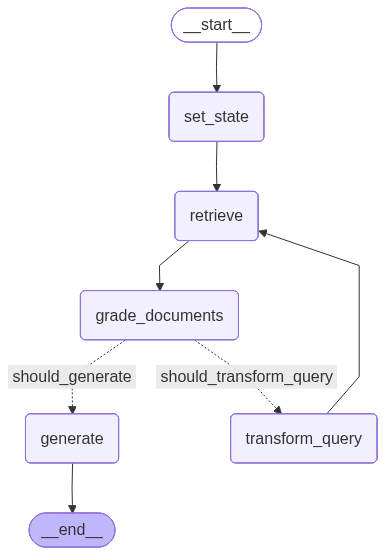

In [57]:

# Visualize our graph
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass